<a href="https://colab.research.google.com/github/aritanaoya/howling_canceler/blob/master/howling_canceller_with_DNCNN_ford8k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install librosa==0.7

     |████████████████████████████████| 1.6MB 2.9MB/s 
  Created wheel for librosa: filename=librosa-0.7.0-cp36-none-any.whl size=1598345 sha256=a7b0f106b082b9133b0b74720412cc135926c9e1205555eacadca73318e0afc5
  Stored in directory: /root/.cache/pip/wheels/49/1d/38/c8ad12fcad67569d8e730c3275be5e581bd589558484a0f881
Successfully built librosa
  Found existing installation: librosa 0.6.3
    Uninstalling librosa-0.6.3:
      Successfully uninstalled librosa-0.6.3


##sin波の生成


In [0]:
import numpy as np
from matplotlib import pyplot as plt
import librosa
import wave
import struct
import librosa.core as lc  
import scipy 
import IPython.display as ipd
import os
import librosa.display



A=0.1#振幅
fs = 8000#サンプリング周波数
f0 = 440#基本周波数(今回はラ)
sec = 2 #秒

#sin波
#--------------------------------------------------------------------------------------------------------------------
def create_wave(A,f0,fs,t):#A:振幅,f0:基本周波数,fs:サンプリング周波数,再生時間[s]
    #nポイント
    #--------------------------------------------------------------------------------------------------------------------
    point = np.arange(0,fs*t)
    sin_wave =A* np.sin(2*np.pi*f0*point/fs)

    sin_wave = [int(x * 32767.0) for x in sin_wave]#16bit符号付き整数に変換

    #バイナリ化
    binwave = struct.pack("h" * len(sin_wave), *sin_wave)

    #サイン波をwavファイルとして書き出し
    w = wave.Wave_write("440Hz.wav")
    p = (1, 2, fs, len(binwave), 'NONE', 'not compressed')#(チャンネル数(1:モノラル,2:ステレオ)、サンプルサイズ(バイト)、サンプリング周波数、フレーム数、圧縮形式(今のところNONEのみ)、圧縮形式を人に判読可能な形にしたもの？通常、 'NONE' に対して 'not compressed' が返されます。)
    w.setparams(p)
    w.writeframes(binwave)
    w.close()
create_wave(A, f0, fs, sec) 

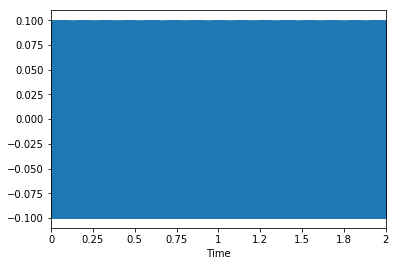

In [3]:
import IPython.display as ipd
def load_sound_files(parent_dir, file_paths):
    raw_sounds = []
    
    for fp in file_paths:
        y,sr = librosa.load(parent_dir + fp, sr=8000,dtype='float32',duration=10)
        #デフォルトでモノラル化、
        raw_sounds.append(y)
    return raw_sounds
sin_file_paths=["440Hz.wav"]
parent_dir3 = '/content/'
sin=[]
sin= load_sound_files(parent_dir3,sin_file_paths)
librosa.display.waveplot(sin[0], 8000)
ipd.Audio(data=sin,rate=8000)

##google driveとの連携

In [0]:
import os, shutil

os.getcwd()
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
id = '1pfqDJw7gAFXM7EguQzvKX3vn0r3VRvrM'  # 共有リンクで取得した id= より後の部分
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('correct_sounds.zip')

In [0]:
id = '1_f9QqOEv7CfDgN4jXGoQ-1Agpoah_lvu'  # 共有リンクで取得した id= より後の部分
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('ford8k.wav.zip')

In [7]:
!unzip ford8k.wav.zip
!ls
import librosa
import librosa.core as lc  
import numpy as np  
import scipy 
import IPython.display as ipd
import os
import matplotlib.pyplot as plt

import librosa.display


Archive:  ford8k.wav.zip
  inflating: ford8k.wav              
   creating: __MACOSX/
  inflating: __MACOSX/._ford8k.wav   
440Hz.wav  correct_sounds.zip  ford8k.wav.zip  sample_data
adc.json   ford8k.wav	       __MACOSX


##音声を読み込み分割

In [8]:
correct_sound,sr =librosa.load("/content/ford8k.wav", sr=8000)
correct_sounds=[]
correct_sounds=np.split(correct_sound,25,axis=0)
print(correct_sounds[1].shape)

(16000,)


In [9]:
ipd.Audio(data=correct_sounds[0],rate=8000)

In [0]:

sin_sounds=[]
for i in range(len(correct_sounds)):
  sin_sounds.append(correct_sounds[i] + sin[0])

#print(sin_sounds)

In [11]:
"""
import wave
import struct
import math
from scipy import fromstring, float32,int16

# 一応既に同じ名前のディレクトリがないか確認。
file = os.path.exists("output2")
print(file)

if file == False:
    #保存先のディレクトリの作成
    os.mkdir("output2")

def cut_wav(filename,time):  # WAVファイルを刈り奪る　形をしてるだろ？ 
    # timeの単位は[sec]

    # ファイルを読み出し
    wavf = filename + '.wav'
    wr = wave.open(wavf, 'r')

    # waveファイルが持つ性質を取得
    ch = wr.getnchannels()
    width = wr.getsampwidth()
    fr = wr.getframerate()
    fn = wr.getnframes()
    total_time = 1.0 * fn / fr
    integer = math.floor(total_time) # 小数点以下切り捨て
    t = int(time)  # 秒数[sec]
    frames = int(ch * fr * t)
    num_cut = int(integer//t)

    #　確認用
    print("Channel: ", ch)
    print("Sample width: ", width)
    print("Frame Rate: ", fr)
    print("Frame num: ", fn)
    print("Params: ", wr.getparams())
    print("Total time: ", total_time)
    print("Total time(integer)",integer)
    print("Time: ", t) 
    print("Frames: ", frames) 
    print("Number of cut: ",num_cut)

    # waveの実データを取得し、数値化
    data = wr.readframes(wr.getnframes())
    wr.close()
    X = fromstring(data, dtype=int16)
    print(X)


    for i in range(num_cut):
        print(i)
        # 出力データを生成
        outf = 'output2/' + str(i) +'.wav'
        start_cut = i*frames
        end_cut = i*frames + frames
        print(start_cut)
        print(end_cut)
        Y = X[start_cut:end_cut]
        outd = struct.pack("h" * len(Y), *Y)

        # 書き出し
        ww = wave.open(outf, 'w')
        ww.setnchannels(ch)
        ww.setsampwidth(width)
        ww.setframerate(fr)
        ww.writeframes(outd)
        ww.close()

print("input filename = ")
f_name = input()
print("cut time = ")
cut_time = input()
cut_wav(f_name,cut_time)
"""

'\nimport wave\nimport struct\nimport math\nfrom scipy import fromstring, float32,int16\n\n# 一応既に同じ名前のディレクトリがないか確認。\nfile = os.path.exists("output2")\nprint(file)\n\nif file == False:\n    #保存先のディレクトリの作成\n    os.mkdir("output2")\n\ndef cut_wav(filename,time):  # WAVファイルを刈り奪る\u3000形をしてるだろ？ \n    # timeの単位は[sec]\n\n    # ファイルを読み出し\n    wavf = filename + \'.wav\'\n    wr = wave.open(wavf, \'r\')\n\n    # waveファイルが持つ性質を取得\n    ch = wr.getnchannels()\n    width = wr.getsampwidth()\n    fr = wr.getframerate()\n    fn = wr.getnframes()\n    total_time = 1.0 * fn / fr\n    integer = math.floor(total_time) # 小数点以下切り捨て\n    t = int(time)  # 秒数[sec]\n    frames = int(ch * fr * t)\n    num_cut = int(integer//t)\n\n    #\u3000確認用\n    print("Channel: ", ch)\n    print("Sample width: ", width)\n    print("Frame Rate: ", fr)\n    print("Frame num: ", fn)\n    print("Params: ", wr.getparams())\n    print("Total time: ", total_time)\n    print("Total time(integer)",integer)\n    print("Time: ", t) \n  

##ハウリングの付着

In [12]:
import random

Fs = 8000
SIMLEN=len(correct_sounds[0])
FIRLEN=100
FC    =7             
DLYLEN=0           
GAIN  =4.0
LIMIT =1.0/GAIN
out_sounds=[]
random.seed(1000)

for j in range(len(correct_sounds)):
  indata = np.array(correct_sounds[j])
  out=np.zeros((0,1)) 
  out=out.flatten()
  firbuf=np.zeros((FIRLEN,1))
  h =np.random.uniform(-1.0,1.0,(100,1))
  h = h - (np.sum(h,axis=0)/FIRLEN)
  h1 = np.zeros((2000-FIRLEN,1))
  hf = np.vstack((h, h1))
  hspec=np.fft.fft(hf)
  hspec=20*np.log10(np.abs(hspec)+1e-100)
  h=h/(10**(np.max(hspec)/20))
  m= 0.0
  for i in range(SIMLEN):
    x=np.zeros((100,1))
    x[0] =m+indata[i]
    #FIR filter
    r=np.dot(h.T, x)
    #apply gain
    y=r*GAIN
    # limiter
    if LIMIT<=np.abs(y):
      m=LIMIT*np.sign(y)
    else: 
      m=y
    # save output data
    out=np.insert(out, i, y)
  out_sounds.append(out/4.0)

#print(SIMLEN)  
print(out_sounds[0].shape)


(16000,)


In [25]:
ipd.Audio(data=out_sounds[4],rate=8000)

In [14]:
#データ数増やすため別パージョン
import random

Fs = 8000
SIMLEN=len(correct_sounds[0])
FIRLEN=100
FC    =7             
DLYLEN=0           
GAIN  =4.0
LIMIT =1.0/GAIN
out_sounds2=[]
random.seed(1000)

for j in range(len(correct_sounds)):
  indata = np.array(correct_sounds[j])
  out=np.zeros((0,1)) 
  out=out.flatten()
  firbuf=np.zeros((FIRLEN,1))
  h =np.random.uniform(-1.0,1.0,(100,1))
  h = h - (np.sum(h,axis=0)/FIRLEN)
  h1 = np.zeros((2000-FIRLEN,1))
  hf = np.vstack((h, h1))
  hspec=np.fft.fft(hf)
  hspec=20*np.log10(np.abs(hspec)+1e-100)
  h=h/(10**(np.max(hspec)/20))
  m= 0.0
  for i in range(SIMLEN):
    x=np.zeros((100,1))
    x[0] =m+indata[i]
    #FIR filter
    r=np.dot(h.T, x)
    #apply gain
    y=r*GAIN
    # limiter
    if LIMIT<=np.abs(y):
      m=LIMIT*np.sign(y)
    else: 
      m=y
    # save output data
    out=np.insert(out, i, y)
  out_sounds2.append(out/4.0)

#print(SIMLEN)  
print(out_sounds2[0].shape)


(16000,)


In [26]:
ipd.Audio(data=out_sounds2[4],rate=8000)

In [61]:
#データ数増やすため別パージョン
import random

Fs = 8000
SIMLEN=len(correct_sounds[0])
FIRLEN=100
FC    =7             
DLYLEN=0           
GAIN  =4.0
LIMIT =1.0/GAIN
out_sounds3=[]
random.seed(1000)

for j in range(len(correct_sounds)):
  indata = np.array(correct_sounds[j])
  out=np.zeros((0,1)) 
  out=out.flatten()
  firbuf=np.zeros((FIRLEN,1))
  h =np.random.uniform(-1.0,1.0,(100,1))
  h = h - (np.sum(h,axis=0)/FIRLEN)
  h1 = np.zeros((2000-FIRLEN,1))
  hf = np.vstack((h, h1))
  hspec=np.fft.fft(hf)
  hspec=20*np.log10(np.abs(hspec)+1e-100)
  h=h/(10**(np.max(hspec)/20))
  m= 0.0
  for i in range(SIMLEN):
    x=np.zeros((100,1))
    x[0] =m+indata[i]
    #FIR filter
    r=np.dot(h.T, x)
    #apply gain
    y=r*GAIN
    # limiter
    if LIMIT<=np.abs(y):
      m=LIMIT*np.sign(y)
    else: 
      m=y
    # save output data
    out=np.insert(out, i, y)
  out_sounds3.append(out/4.0)

#print(SIMLEN)  
print(out_sounds3[0].shape)


(16000,)


In [62]:
ipd.Audio(data=out_sounds3[4],rate=8000)

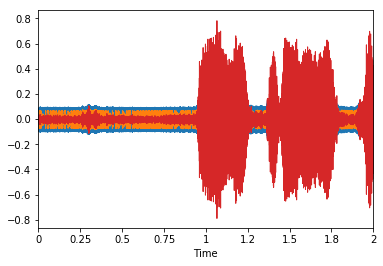

In [63]:
librosa.display.waveplot(out_sounds[4], 8000)
librosa.display.waveplot(out_sounds2[4], 8000)
librosa.display.waveplot(out_sounds3[4], 8000)
librosa.display.waveplot(correct_sounds[4], 8000)

## Get the power spectrogram

In [33]:
def cal_power_spectrogram(y):
  x=[]
  for i in  range(len(y)):
    x.append(np.abs(librosa.stft(y[i],n_fft = 1024)))
  return x

train_files=[]
train_noisy_files =[]
train_noisy_files2 =[]
train_files = cal_power_spectrogram(correct_sounds)
print(train_files[0].shape)
train_noisy_files = cal_power_spectrogram(out_sounds)
train_noisy_files2 = cal_power_spectrogram(out_sounds2)
x = np.array(train_files)
train_files1 =np.log(x + 1e-10)
x1  = np.array(train_noisy_files)
train_noisy_files1 =np.log(x1+ 1e-10)
x2  = np.array(train_noisy_files2)
train_noisy_files2 =np.log(x1+ 1e-10)

(513, 63)


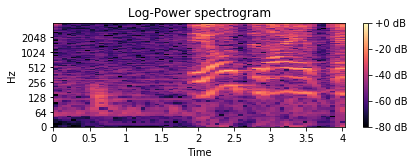

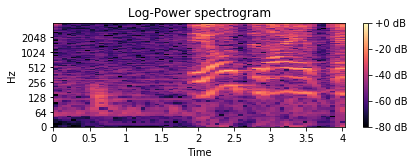

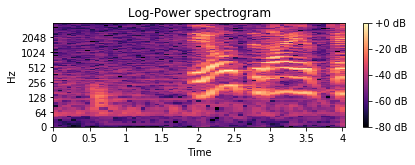

In [35]:
#音声プロット
#パワースペクトルと対数パワースペクトル

def plt_power_spec(S,sr):
  plt.figure()
  plt.subplot(2, 1, 2)
  #S1 = np.exp(S)
  librosa.display.specshow(librosa.power_to_db(S**2, ref=np.max),
                         sr=sr, y_axis='log', x_axis='time')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Log-Power spectrogram')
  plt.tight_layout()
  plt.show()
  
  
plt_power_spec(np.exp(train_noisy_files2[4]),8000)
plt_power_spec(np.exp(train_noisy_files1[4]),8000)
plt_power_spec(np.exp(train_files1[4]),8000)



(15872,)


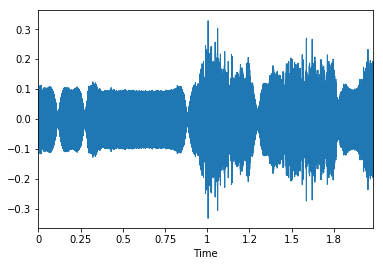

In [36]:
y0=np.exp(train_noisy_files2[4])
y1=lc.griffinlim(y0)
print(y1.shape)
librosa.display.waveplot(y1, 8000)
ipd.Audio(data=y1,rate=8000)


##型の変更,生成

In [41]:
freq = 513
time = 63

train_num =25
test_num = 5

#型の変更
x_train = np.zeros(freq*time*train_num).reshape(train_num, freq, time)
x_train_noisy=np.zeros(freq*time*train_num).reshape(train_num, freq, time)
x_train_noisy2=np.zeros(freq*time*train_num).reshape(train_num, freq, time)

print(x_train.shape)
print(x_train_noisy.shape)

(25, 513, 63)
(25, 513, 63)


In [42]:
#print(train_noisy_files[0])
def min_max(x, axis=None):
    xmin = x.min(axis=axis, keepdims=True)
    xmax = x.max(axis=axis, keepdims=True)
    result = (x- xmin)/(xmax-xmin)

    return result, xmin ,xmax


#正規化
x_train , trainmin , trainmax = min_max(train_files1)
x_train_noisy, trainmin_noisy, trainmax_noisy = min_max(train_noisy_files1)
x_train_noisy2, trainmin_noisy2, trainmax_noisy2 = min_max(train_noisy_files2)
print(x_train.shape)

(25, 513, 63)


In [43]:

# CNN用にデータを(batch_size, freq, time, 1)にreshape    
x_train_re=x_train.reshape(train_num, freq, time, 1)
x_train_noisy_re=x_train_noisy.reshape(train_num, freq, time, 1)
x_train_noisy2_re=x_train_noisy2.reshape(train_num, freq, time, 1)
print(x_train_re.shape)
print(x_train_noisy_re.shape)

(25, 513, 63, 1)
(25, 513, 63, 1)


##Deep Learning

In [0]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten,Reshape,MaxPooling2D,UpSampling2D
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers

# DNCNN
input_img = Input(shape=(513, 63, 1))
x = Conv2D(64, (3,3), padding='same')(input_img)
x = Activation('relu')(x)

for i in range(15):
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

x = Conv2D(1, (3, 3), padding='same')(x)
output_img = Activation('tanh')(x)

# compile
model = Model(input_img, output_img)
model.compile(optimizer='adam', loss='mean_squared_error')


In [45]:
x_train1 = x_train_re[0:20,:,:,:]
x_noisy1 = x_train_noisy_re[0:20,:,:,:]
x_noisy2 = x_train_noisy2_re[0:20,:,:,:]
x_val = x_train_re[20:,:,:,:]
x_noisy_val =x_train_noisy_re[20:,:,:,:]
x_noisy_val2 =x_train_noisy2_re[20:,:,:,:]
print(x_val.shape)
print(x_noisy_val.shape)


(5, 513, 63, 1)
(5, 513, 63, 1)


In [46]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 513, 63, 1)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 513, 63, 64)       640       
_________________________________________________________________
activation_18 (Activation)   (None, 513, 63, 64)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 513, 63, 64)       36928     
_________________________________________________________________
batch_normalization_16 (Batc (None, 513, 63, 64)       256       
_________________________________________________________________
activation_19 (Activation)   (None, 513, 63, 64)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 513, 63, 64)       3692

##パラメタ調節

In [0]:
batch_size = 1
epochs = 50
saveDir = "/content/howling_canceller_wiith_DNCNN"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

##訓練

In [49]:

def get_batch(x, y, batch_size, shuffle=False):
    '''ミニバッチを生成するジェネレーター関数
    '''
    num_samples = len(x)
    if shuffle:
        indices = np.random.permutation(num_samples)
    else:
        indices = np.random.arange(num_samples)
    num_iterations = np.ceil(num_samples / batch_size).astype(int)
    for itr in range(num_iterations):
        start = batch_size * itr
        excerpt = indices[start:start + batch_size]
        yield x[excerpt], y[excerpt]
# train
for i in range(epochs):
  for x_batch, y_batch in get_batch(x_noisy1, x_train1, batch_size=1, shuffle=True):
    history = model.train_on_batch(x_batch, y_batch)
  test = model.evaluate(x_noisy_val,x_val)
  print("epoch:",i+1)
  print("test:",test)

  for x_batch2, y_batch2 in get_batch(x_noisy2, x_train1, batch_size=1, shuffle=True):
    history = model.train_on_batch(x_batch2, y_batch2)
  test = model.evaluate(x_noisy_val2,x_val)
  print("epoch:",i+1)
  print("test:",test)

5/5 [==============================] - 0s 30ms/step
epoch: 1
test: 0.005551318172365427
5/5 [==============================] - 0s 31ms/step
epoch: 1
test: 0.005532267969101667
5/5 [==============================] - 0s 31ms/step
epoch: 2
test: 0.004781672265380621
5/5 [==============================] - 0s 31ms/step
epoch: 2
test: 0.004502876661717892
5/5 [==============================] - 0s 31ms/step
epoch: 3
test: 0.0045524160377681255
5/5 [==============================] - 0s 31ms/step
epoch: 3
test: 0.005090809427201748
5/5 [==============================] - 0s 31ms/step
epoch: 4
test: 0.004907005000859499
5/5 [==============================] - 0s 31ms/step
epoch: 4
test: 0.004277612082660198
5/5 [==============================] - 0s 31ms/step
epoch: 5
test: 0.004233603831380606
5/5 [==============================] - 0s 31ms/step
epoch: 5
test: 0.004325625021010637
5/5 [==============================] - 0s 31ms/step
epoch: 6
test: 0.004721140488982201
5/5 [==========================

In [65]:

# options
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = saveDir + '/how_canceller_win5rb_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# train
history = model.fit(x_noisy1, x_train1,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_noisy_val, x_val),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)
              


Train on 20 samples, validate on 5 samples
Epoch 1/100
20/20 [==============================] - 3s 164ms/step - loss: 0.0032 - val_loss: 0.0869

Epoch 00001: val_loss improved from inf to 0.08686, saving model to /content/howling_canceller_wiith_DNCNN/how_canceller_win5rb_weights.01-0.00-0.09.hdf5
Epoch 2/100
20/20 [==============================] - 3s 157ms/step - loss: 0.0034 - val_loss: 0.0869

Epoch 00002: val_loss improved from 0.08686 to 0.08686, saving model to /content/howling_canceller_wiith_DNCNN/how_canceller_win5rb_weights.02-0.00-0.09.hdf5
Epoch 3/100
20/20 [==============================] - 3s 157ms/step - loss: 0.0028 - val_loss: 0.0354

Epoch 00003: val_loss improved from 0.08686 to 0.03542, saving model to /content/howling_canceller_wiith_DNCNN/how_canceller_win5rb_weights.03-0.00-0.04.hdf5
Epoch 4/100
20/20 [==============================] - 3s 157ms/step - loss: 0.0026 - val_loss: 0.0464

Epoch 00004: val_loss did not improve from 0.03542
Epoch 5/100
20/20 [=========

##predict

In [0]:
how_cancel=model.predict(x_noisy_val)
#how_cancel_reshape=how_cancel1.reshape(125,513,63*1)
#how_cancel_re=np.zeros(freq*time*test_num*len(how_cancel1)).reshape(test_num*len(how_cancel1), freq, time)
#for i in range(len(x_noisy_val)):
#  how_cancel_re[i*test_num:(i+1)*test_num] = how_cancel_reshape

In [0]:
how_cancel1 = np.exp(how_cancel * (trainmax_noisy - trainmin_noisy) + trainmin_noisy)

In [52]:
how_cancel1=[]
how_cancel_re=[]
how_cancel_gri=[]
for i in range(len(how_cancel)):
  how_cancel1.append(np.exp(how_cancel[i] * (trainmax_noisy - trainmin_noisy) + trainmin_noisy))
  how_cancel_re.append(how_cancel1[i].reshape(513,63*1))
  how_cancel_gri.append(lc.griffinlim(how_cancel_re[i]))

#how_cancel_gri =np.array(how_cancel_gri)

cancel=np.concatenate([how_cancel_gri[0], how_cancel_gri[1],how_cancel_gri[2],how_cancel_gri[3],how_cancel_gri[4]],axis =0)
print(cancel.shape)

(79360,)


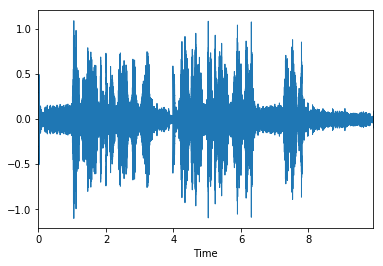

In [53]:
librosa.display.waveplot(cancel, sr=8000)
ipd.Audio(data=cancel,rate=8000)

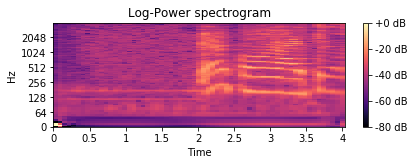

In [54]:
plt_power_spec(how_cancel_re[0],8000)

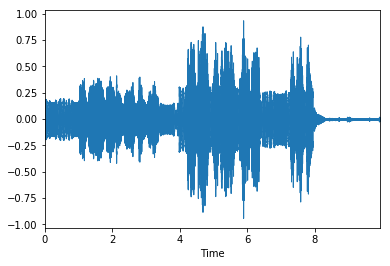

In [59]:
y0=[]
y=[]
y_gri=[]
for i in range(len(how_cancel)):
  y0.append(np.exp(x_noisy_val[i]*(trainmax_noisy - trainmin_noisy) + trainmin_noisy))
  y.append(y0[i].reshape(513,63*1))
  y_gri.append(lc.griffinlim(y[i]))

noisy=np.concatenate([y_gri[0], y_gri[1],y_gri[2],y_gri[3],y_gri[4]],axis =0)
librosa.display.waveplot(noisy, sr=8000)
ipd.Audio(data=noisy,rate=8000)



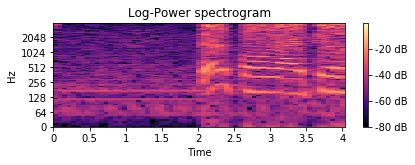

In [60]:
plt_power_spec(y[0],8000)

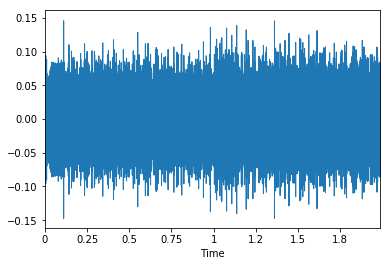

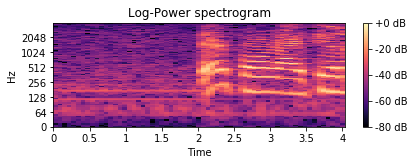

In [0]:
plt_power_spec(y1,8000)